In [1]:
import tqdm
import random
import pathlib
import itertools
import collections
import glob
import os
import cv2
import numpy as np
import remotezip as rz

import tensorflow as tf

import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

# Тема: Машинное обучение в задачах извлечения знаний из видеоданных. 

# Цель: Написать нейронную сеть которая будет определятьь какой вид спорта показан в видео


## 1. Загрузка файлов и создание датасета

Для работы я взял датасет UCF101, он представляет собой крупномасштабный набор видеоданных, всего содержащий 101 классов. Он включает в себя 13 320 видеоклипов (собранных с YouTube).



Набор данных включает в себя различные точки обзора, масштабы, движение камеры и условия освещения, что делает его сложным набором данных для задач распознавания действи». Он широко используется в качестве эталонного набора данных в компьютерном зрении для обучения и оценки моделей распознавания действий.

In [48]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
def list_files_from_zip_url(zip_url):
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [49]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

In [4]:
def get_class(fname):
    return fname.split('_')[1]
    
def get_files_per_class(files):
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

In [5]:
NUM_CLASSES = 6
FILES_PER_CLASS = 100

In [6]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [7]:
files_for_class

defaultdict(list,
            {'ApplyEyeMakeup': ['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
              'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
              'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
              'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
              'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
              'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
              'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
              'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
              'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
              'UCF101/v_ApplyEyeMakeup_g02_c04.avi',
              'UCF101/v_ApplyEyeMakeup_g03_c01.avi',
              'UCF101/v_ApplyEyeMakeup_g03_c02.avi',
              'UCF101/v_ApplyEyeMakeup_g03_c03.avi',
              'UCF101/v_ApplyEyeMakeup_g03_c04.avi',
              'UCF101/v_ApplyEyeMakeup_g03_c05.avi',
              'UCF101/v_ApplyEyeMakeup_g03_c06.avi',
              'UCF101/v_ApplyEyeMakeup_g04_c01.avi',
              'UCF101/v_ApplyEyeMakeup_g04_c02.avi',
          

In [8]:
classes

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress',
 'Biking',
 'Billiards',
 'BlowDryHair',
 'BlowingCandles',
 'BodyWeightSquats',
 'Bowling',
 'BoxingPunchingBag',
 'BoxingSpeedBag',
 'BreastStroke',
 'BrushingTeeth',
 'CleanAndJerk',
 'CliffDiving',
 'CricketBowling',
 'CricketShot',
 'CuttingInKitchen',
 'Diving',
 'Drumming',
 'Fencing',
 'FieldHockeyPenalty',
 'FloorGymnastics',
 'FrisbeeCatch',
 'FrontCrawl',
 'GolfSwing',
 'Haircut',
 'Hammering',
 'HammerThrow',
 'HandstandPushups',
 'HandstandWalking',
 'HeadMassage',
 'HighJump',
 'HorseRace',
 'HorseRiding',
 'HulaHoop',
 'IceDancing',
 'JavelinThrow',
 'JugglingBalls',
 'JumpingJack',
 'JumpRope',
 'Kayaking',
 'Knitting',
 'LongJump',
 'Lunges',
 'MilitaryParade',
 'Mixing',
 'MoppingFloor',
 'Nunchucks',
 'ParallelBars',
 'PizzaTossing',
 'PlayingCello',
 'PlayingDaf',
 'PlayingDhol',
 'PlayingFlute',
 'Play

Для обучения своей модели я буду использовать только 4 класса видео : Basketball, SoccerPenalty, TableTennisShot, VolleyballSpiking. Так как объем выборки не очень большой , модель не сможет различать большее кол-во классов

In [50]:
def select_subset_of_classes(files_for_class, classes, files_per_class):

  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset


In [10]:
files_subset = select_subset_of_classes(files_for_class, ['Basketball','SoccerPenalty','TableTennisShot','VolleyballSpiking'], 100)
list(map(len,files_subset.values()))

[100, 100, 100, 100]

In [11]:
lst=[]
for i in files_subset.keys():
    lst.extend([*files_subset[i]])
len(lst)

400

In [14]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df=pd.DataFrame(lst,columns=['action'])
df['sport']=df['action'].apply(lambda x: x.split('_')[1])

In [15]:
df

action              sport
0           UCF101/v_Basketball_g01_c01.avi         Basketball
1           UCF101/v_Basketball_g01_c02.avi         Basketball
2           UCF101/v_Basketball_g01_c03.avi         Basketball
3           UCF101/v_Basketball_g01_c04.avi         Basketball
4           UCF101/v_Basketball_g01_c05.avi         Basketball
..                                      ...                ...
395  UCF101/v_VolleyballSpiking_g20_c04.avi  VolleyballSpiking
396  UCF101/v_VolleyballSpiking_g21_c01.avi  VolleyballSpiking
397  UCF101/v_VolleyballSpiking_g21_c02.avi  VolleyballSpiking
398  UCF101/v_VolleyballSpiking_g21_c03.avi  VolleyballSpiking
399  UCF101/v_VolleyballSpiking_g21_c04.avi  VolleyballSpiking

[400 rows x 2 columns]

Датасет представлеят из себя набор данных , где action -название файла  , sport - вид спорта, который представлен в видео

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   action  400 non-null    object
 1   sport   400 non-null    object
dtypes: object(2)
memory usage: 6.4+ KB


В датасете нет пустых значений

Далее я скачиваю датасет и разбиваю его на train и test выборки, при этом отношение классов одинаковое  в обоих выборках

In [16]:
def download_from_zip(zip_url, to_dir, file_names):
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

In [17]:
def split_class_lists(files_for_class, count):
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

In [19]:
def download_ucf_101_subset(zip_url, num_classes, splits, download_dir):
  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) 



  classes = num_classes

  for cls in classes:
    random.shuffle(files_subset[cls])

  files_for_class = {x: files_subset[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

In [20]:
download_dir = pathlib.Path('./UCF101_subset/')

cls=['Basketball','SoccerPenalty','TableTennisShot','VolleyballSpiking']
subset_paths = download_ucf_101_subset(URL,
                                       num_classes = cls,
                                       splits = {"train": 70,"test": 30},
                                       download_dir = download_dir)

train :
test :


## 2 Предобработка данных  

In [21]:
def format_frames(frame, output_size):

  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

Разбиение видеофайла на определенное кол-во кадров и преобразование каждого кадра в тензор 

In [22]:
def frames_from_video_file(video_path, n_frames=10, output_size = (224,224), frame_step = 15):


  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [24]:
test_names = []
test_features=[]
for file_path in list(subset_paths['test'].glob('*/*.avi')):
  test_names.append(file_path.name)
  test_features.append(frames_from_video_file(file_path))



test_features

[array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

In [25]:

import numpy as np
test_features = np.array(test_features)

In [26]:
train_names = []
train_features=[]
for file_path in list(subset_paths['train'].glob('*/*.avi')):
  train_names.append(file_path.name)
  train_features.append(frames_from_video_file(file_path))



train_features

[array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

In [27]:
import numpy as np
train_features = np.array(train_features)

In [28]:
train_labels=list(map(lambda x : x.split("_")[1],train_names))
train_labels

['Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketba

In [29]:
test_labels=list(map(lambda x : x.split("_")[1],test_names))
test_labels


['Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'Basketball',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'SoccerPenalty',
 'TableTen

Преобразование категориальных признаков из текста в число с помощью labelEncoder

In [30]:
le=LabelEncoder()
test_labels=np.array(le.fit_transform(test_labels))
train_labels=np.array(le.fit_transform(train_labels))

In [31]:
train_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)

In [32]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)

In [33]:
np.array(train_labels).shape

(280,)

Визуализация одного из преобразованного тензора

In [34]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


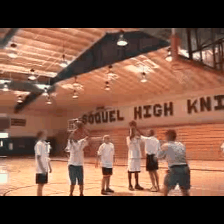

In [35]:
to_gif(train_features[60])

## 3 Построение модели

Для данной задачи я построю 2 нейронные сети: 
1. Базовая нейронная сеть основанная на Conv3D
2. Предобученная модель EfficientNet

Так как это задача классификация в качестве метрик я буду использовать accuracy,precision , recall и F1-score.

accuracy - показывает долю правильных классификаций.


precision - показывает отношение верно классифицированных объектов класса к общему числу элементов этого класса.


recall - показывает долю верно классифицированных объектов среди всех объектов, которые к этому классу отнес классификатор.



In [36]:
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).shuffle(32 * 4).batch(32).cache().prefetch(tf.data.AUTOTUNE)

In [37]:
valid_ds = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(32).cache().prefetch(tf.data.AUTOTUNE)

Sequential: Sequential в Keras позволяет создавать слои последовательно, где каждый слой имеет входы только из предыдущего слоя.


Conv3d : Этот слой создает ядро свертки, которое свертывается с входными данными слоя по одному пространственному (или временному) измерению для создания тензора выходных данных.


Maxpooling3D : Это слой который помогает уменьшить размерность данных, принимая максимальное значение в окне ввода (размер которого определяется параметром Pool_size) для каждого канала ввода.


Dense: Этот слой реализует операцию: output = activation(dot(input, kernel) + bias)


Activation: функции активации, такие как ReLU и softmax, определяют, какие нейроны будут активироваться в сети, добавляя нелинейность, необходимую для обучения сложных задач.


In [54]:
model1 = tf.keras.Sequential([
    tf.keras.Input(shape=(10, 224, 224, 3)),
    tf.keras.layers.Conv3D(32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Conv3D(64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Conv3D(128, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(len(cls), activation="softmax")
])
model1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=[
        "accuracy"
    ]
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 10, 224, 224, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 5, 112, 112, 32)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 5, 112, 112, 64)     │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 2, 56, 56, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 2, 56, 56, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 1, 28, 28, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 28, 28, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 279,812 (1.07 MB)

 Trainable params: 279,812 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:

history = model1.fit(
    train_ds,
    epochs=30,
    validation_data=valid_ds,
)



Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 66s 7s/step - accuracy: 0.1961 - loss: 1.4591 - val_accuracy: 0.2500 - val_loss: 1.3840
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.3183 - loss: 1.3755 - val_accuracy: 0.4000 - val_loss: 1.3849
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.4031 - loss: 1.3846 - val_accuracy: 0.4250 - val_loss: 1.3844
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.4885 - loss: 1.3832 - val_accuracy: 0.4000 - val_loss: 1.3774
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.5607 - loss: 1.3692 - val_accuracy: 0.3500 - val_loss: 1.3488
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.4704 - loss: 1.3183 - val_accuracy: 0.2833 - val_loss: 1.3217
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step - accuracy: 0.4442 - loss: 1.2487 - val_accuracy: 0.4250 - val_loss: 1.2043
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.5528 - loss: 1.0814 - val_accuracy: 0.4917 - val_loss: 1.0503
Epoch 9/

In [37]:
history.history

{'accuracy': [0.20000000298023224,
  0.3791666626930237,
  0.38333332538604736,
  0.4000000059604645,
  0.38333332538604736,
  0.4416666626930237,
  0.512499988079071,
  0.5041666626930237,
  0.5458333492279053,
  0.5958333611488342,
  0.5958333611488342,
  0.574999988079071,
  0.5375000238418579,
  0.6083333492279053,
  0.625,
  0.625,
  0.6666666865348816,
  0.7083333134651184,
  0.699999988079071,
  0.7124999761581421,
  0.7416666746139526,
  0.7333333492279053,
  0.737500011920929,
  0.75,
  0.7583333253860474,
  0.7791666388511658,
  0.7875000238418579,
  0.7791666388511658,
  0.7749999761581421,
  0.8166666626930237],
 'loss': [1.457776427268982,
  1.3730065822601318,
  1.3371071815490723,
  1.2314444780349731,
  1.1424998044967651,
  1.0518031120300293,
  1.0295644998550415,
  1.09882390499115,
  1.0240740776062012,
  0.9085840582847595,
  0.8619509339332581,
  0.8391053080558777,
  0.8519896268844604,
  0.8051971793174744,
  0.7737405300140381,
  0.753622829914093,
  0.69947081

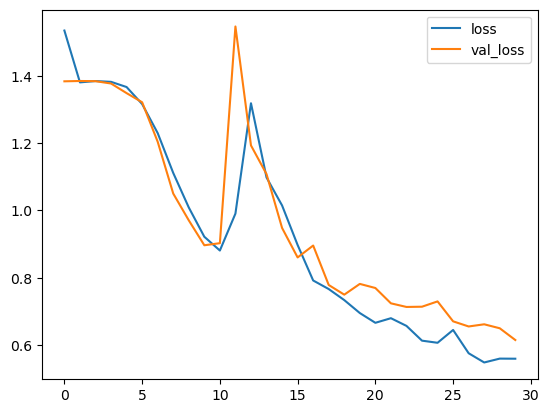

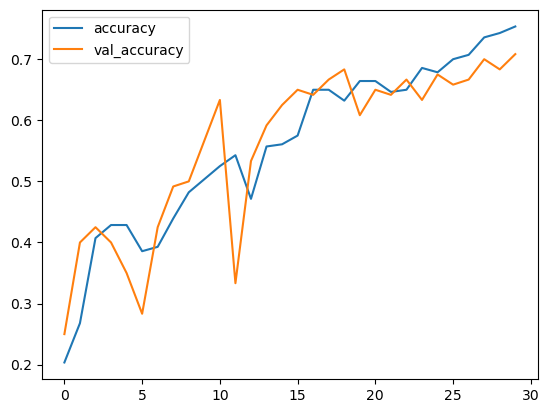

In [56]:
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()


мы можем увидеть, что модел не переобучается

In [58]:
val_loss, val_acc = model1.evaluate(valid_ds)
print(f"Validation Loss:{val_loss} Validation Accuracy:{val_acc}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 869ms/step - accuracy: 0.6708 - loss: 0.6451
Validation Loss:0.6149948835372925 Validation Accuracy:0.7083333134651184


Точность модели на тестовой выборки равняется  0.71, что довольно неплохо, так как качественное обучение сверточной нейронной сети  c 0 довольно ресурсоемкая и длительная работа, и полностью обучить модель в домашних условиях практически невозможно

In [42]:

def get_actual_predicted_labels(model,dataset): 

  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted



 

In [70]:
actual, predicted = get_actual_predicted_labels(model1,valid_ds)
cm=tf.math.confusion_matrix(actual,predicted)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 864ms/step


Также построим матрицу ошибок, из нее мы можем увидеть в каких классах и как модель ошибается

In [76]:
cm

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[14,  0,  5, 11],
       [ 0, 28,  2,  0],
       [ 2,  0, 23,  5],
       [ 6,  0,  4, 20]])>

In [43]:
def calculate_classification_metrics(y_actual, y_pred, labels):

  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) 
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] 
    row = cm[i, :]
    fn = np.sum(row) - tp[i] 

    precision[labels[i]] = tp[i] / (tp[i] + fp)  

    recall[labels[i]] = tp[i] / (tp[i] + fn) 

  return precision, recall

In [90]:
precision, recall = calculate_classification_metrics(actual, predicted, cls)
precision,recall

({'Basketball': 0.6363636363636364,
  'SoccerPenalty': 1.0,
  'TableTennisShot': 0.6764705882352942,
  'VolleyballSpiking': 0.5555555555555556},
 {'Basketball': 0.4666666666666667,
  'SoccerPenalty': 0.9333333333333333,
  'TableTennisShot': 0.7666666666666667,
  'VolleyballSpiking': 0.6666666666666666})

precicion, recall для каждого класса так как , это множественная классификация можно вычислить среднее по всем классам и получить метрики для модели

In [91]:
np.array(list(precision.values())).mean(),np.array(list(recall.values())).mean()

(0.7170974450386214, 0.7083333333333333)

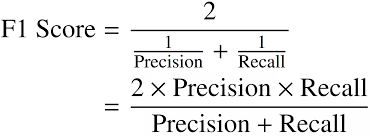

In [95]:
F1_score=2/(1/np.array(list(precision.values()))+1/np.array(list(recall.values()))).mean();F1_score

0.6740632195938873

Подводя итог результатам метрик данной модели можно сделать вывод , что  точность модели на тестовой выборки  довольно неплохая, так как качественное обучение сверточной нейронной сети  c 0 довольно ресурсоемкая и длительная работа, и полностью обучить модель в домашних условиях, которая идеально предсказывает, практически невозможно

EfficientNet — это архитектура сверточной нейронной сети и метод масштабирования, который равномерно масштабирует все измерения глубины/ширины/разрешения с использованием составного коэффициента. В отличие от традиционной практики произвольного масштабирования этих факторов, метод масштабирования EfficientNet равномерно масштабирует ширину, глубину и разрешение сети с помощью набора фиксированных коэффициентов масштабирования.

In [38]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

history=model.fit(train_ds,
          epochs = 10,
          validation_data = valid_ds)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 188s 9s/step - accuracy: 0.2421 - loss: 2.1943 - val_accuracy: 0.6583 - val_loss: 1.3765
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.7886 - loss: 1.1801 - val_accuracy: 0.7750 - val_loss: 0.8830
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.9194 - loss: 0.7747 - val_accuracy: 0.9167 - val_loss: 0.6384
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.9593 - loss: 0.5741 - val_accuracy: 0.9500 - val_loss: 0.4963
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - accuracy: 0.9822 - loss: 0.4492 - val_accuracy: 0.9750 - val_loss: 0.4052
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.9768 - loss: 0.3561 - val_accuracy: 0.9750 - val_loss: 0.3435
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.9917 - loss: 0.2951 - val_accuracy: 0.9750 - val_loss: 0.2986
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.9829 - loss: 0.2539 - val_accuracy: 0.9833 - val_loss: 0.2644
Epoch 9

In [39]:
model.evaluate(valid_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.9819 - loss: 0.2118


[0.21609114110469818, 0.9833333492279053]

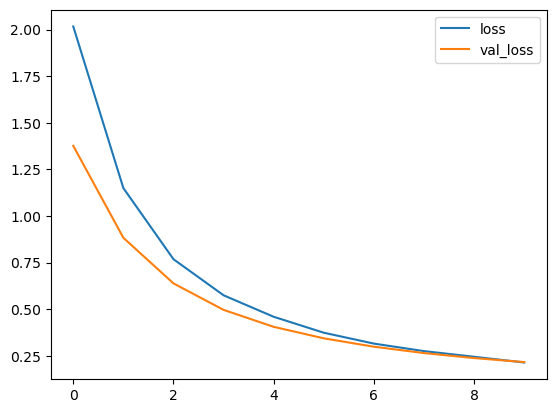

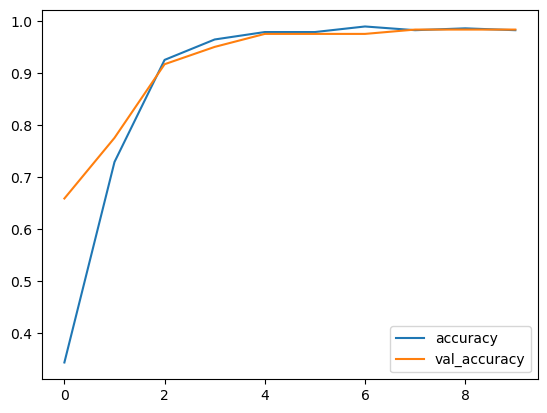

In [40]:
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()

По графику видно, что модель не переобучилась и не недообучилась

In [44]:
actual, predicted = get_actual_predicted_labels(model,valid_ds)
tf.math.confusion_matrix(actual,predicted)

4/4 ━━━━━━━━━━━━━━━━━━━━ 63s 12s/step


<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[29,  0,  0,  1],
       [ 0, 30,  0,  0],
       [ 0,  0, 30,  0],
       [ 1,  0,  0, 29]])>

In [45]:
precision, recall = calculate_classification_metrics(actual, predicted, cls)
precision,recall

({'Basketball': 0.9666666666666667,
  'SoccerPenalty': 1.0,
  'TableTennisShot': 1.0,
  'VolleyballSpiking': 0.9666666666666667},
 {'Basketball': 0.9666666666666667,
  'SoccerPenalty': 1.0,
  'TableTennisShot': 1.0,
  'VolleyballSpiking': 0.9666666666666667})

In [46]:
np.array(list(precision.values())).mean(),np.array(list(recall.values())).mean()

(0.9833333333333334, 0.9833333333333334)

In [47]:
F1_score=2/(1/np.array(list(precision.values()))+1/np.array(list(recall.values()))).mean();F1_score

0.9830508474576272

Используя такие же метрики как и для обычной сверточной нейронной сети мы можем увидеть, что модель ведет себя намного лучше и практически предсказывает вид спорта без ошибок

## Вывод
Подводя итог данной работы данной работы можно сделать вывод, что на малом обьеме выборке лучше использовать Elasticnet- предобученную модель ее также называют transfer learning. Хотя обычная сверточная нейарнная сеть тоже может лать хороший результат, но для этого необходим больший датасет, и что более проблематично больше вычислительных мощностей